In [2]:
import numpy as np
import scipy as p
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
from scipy import odr

In [ ]:
def STLSQ(Theta: np.ndarray,dXdt: np.ndarray, lambd: float, n_iter: int = 10) -> np.ndarray:
                                                        
    # Initial ordinary least-squares fit
    Xi, *_ = np.linalg.lstsq(Theta, dXdt, rcond=None)

    for _ in range(n_iter):
        # Hard-threshold small coefficients
        smallinds = np.abs(Xi) < lambd
        Xi[smallinds] = 0.0

        # For each state variable, refit using the remaining “large” basis functions
        for ind in range(Xi.shape[1]):      # n = Xi.shape[1] (state dimension)
            biginds = ~smallinds[:, ind]    # True means this basis function is kept
            if not np.any(biginds):
                continue                    # Skip if the entire column was zeroed
            Xi[biginds, ind], *_ = np.linalg.lstsq(
                Theta[:, biginds],          # Reduced library matrix
                dXdt[:, ind],               # Target derivative for this state
                rcond=None
            )

    return Xi


True coefficients:      [ 3.  -2.   0.   0.5  0.   1. ]
Recovered coefficients: [ 3.01960013 -2.08989875 -0.20507489  0.84404811  0.25640407  0.70278417]
λ (threshold) chosen:   0.18456740206273323


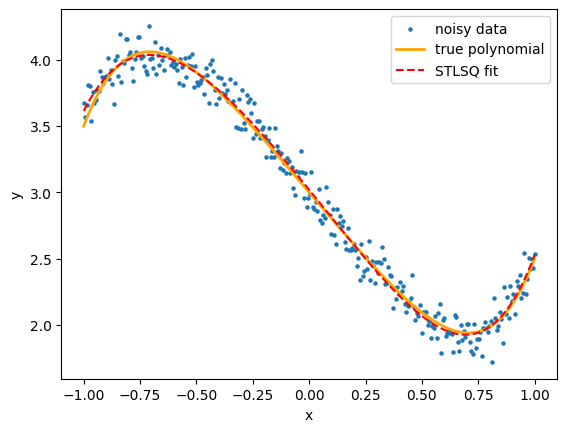

In [14]:
np.random.seed(0)

m = 300                                   # number of samples
x = np.linspace(-1, 1, m)
true_coeffs = np.array([3.0, -2.0, 0.0, 0.5, 0.0, 1])   # up to x^5
deg = len(true_coeffs) - 1
y_clean = sum(c * x**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)               # add y-noise only

# Build polynomial library Θ(x) = [1, x, x^2, …, x^deg]
Theta = np.vstack([x**k for k in range(deg + 1)]).T        # m × (deg+1)

# Choose λ slightly below the smallest non-zero coefficient
Xi_initial, *_ = np.linalg.lstsq(Theta, y_noisy[:, None], rcond=None)
nz = np.abs(Xi_initial)[np.abs(Xi_initial) > 1e-12]        # filter exact zeros
lambd = 0.9*nz.min()                                     # 90% of smallest non-zero

Xi_sparse = STLSQ(Theta, y_noisy[:, None], lambd=lambd, n_iter=10).ravel()    # flatten to 1-D

print("True coefficients:     ", true_coeffs)
print("Recovered coefficients:", Xi_sparse)
print("λ (threshold) chosen:  ", lambd)

y_fit = sum(Xi_sparse[k] * x**k for k in range(deg + 1))
plt.scatter(x, y_noisy, s=5, label='noisy data')
plt.plot(x, y_clean, color='orange', linewidth=2, label='true polynomial')
plt.plot(x, y_fit, '--', color='red', linewidth=1.5, label='STLSQ fit')
plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.show()

True  coeffs: [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 3.03538024 -1.85913891 -0.30013402  0.          0.35661278  1.34951778]
Chosen λ: 0.2758531617629184


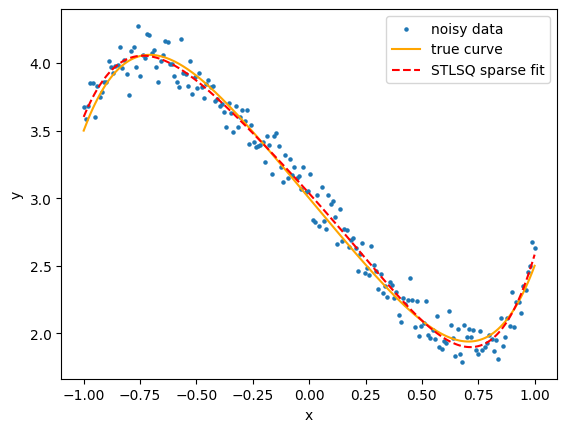

In [18]:
np.random.seed(0)
m = 200
x = np.linspace(-1, 1, m)
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])   
deg = len(true_coeffs) - 1
y_clean = sum(c * x**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)

#  Construct and normalize the polynomial library
Theta = np.vstack([x**k for k in range(deg + 1)]).T
col_norms = np.linalg.norm(Theta, axis=0)
Theta_n = Theta / col_norms                     # Normalize each column to unit norm
y = y_noisy[:, None]


# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)                # 0.001 → 1
best_bic, best_Xi, best_lam = np.inf, None, None
n = len(y_noisy)

for lam in lambdas:
    Xi_n = STLSQ(Theta_n, y, lam)               # Sparse regression on normalized library
    Xi = Xi_n / col_norms[:, None]              # Scale coefficients back

    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k = np.count_nonzero(Xi)                    # # Number of non-zero coefficients
    bic = n * np.log(rss / n) + k * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

#
print("True  coeffs:", true_coeffs)
print("Sparse coeffs:", best_Xi)
print("Chosen λ:", best_lam)

y_fit = sum(best_Xi[k] * x**k for k in range(deg + 1))
plt.scatter(x, y_noisy, s=5, label="noisy data")
plt.plot(x, y_clean, color = "orange", lw=1.5, label="true curve")
plt.plot(x, y_fit, "--", color = "red", lw=1.5, label="STLSQ sparse fit")
plt.legend(); plt.xlabel("x"); plt.ylabel("y"); plt.show()

In [23]:
def _odr_fit(A: np.ndarray, b: np.ndarray, beta0: np.ndarray | None = None) -> np.ndarray:
 
    # linear model:  y = beta · x
    def lin_model(beta, x):
        return np.dot(beta, x)

    model = odr.Model(lin_model)
    data  = odr.RealData(A.T, b)            # ODR requires x dimensions to be placed on the 1st axis.

    if beta0 is None:                       # LSQ as the initial value
        beta0 = np.linalg.lstsq(A, b, rcond=None)[0]

    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta


def STLSQ_ODR(Theta: np.ndarray,
              dXdt: np.ndarray,
              lambd: float,
              n_iter: int = 10) -> np.ndarray:

    n_features, n_states = Theta.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    # ODR fit
    for k in range(n_states):
        Xi[:, k] = _odr_fit(Theta, dXdt[:, k])

    # Iteration: thresholding + refitting
    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0

        # Large coefficients retained by re-ODR fitting for each state
        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue
            Xi[keep, k] = _odr_fit(Theta[:, keep], dXdt[:, k])

    return Xi

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9877 -2.0156  0.      0.563   0.      0.9521]
Chosen λ     : 0.6260516572014821


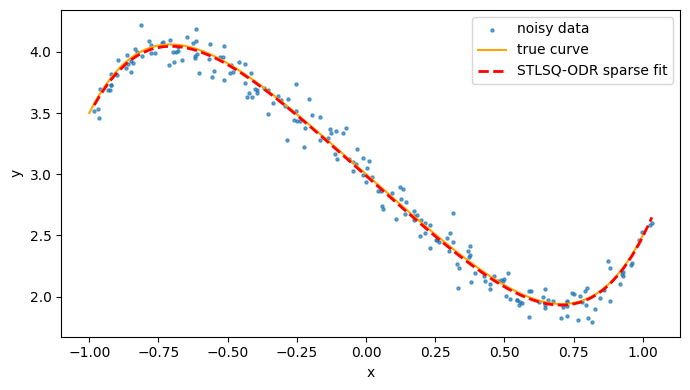

In [29]:
np.random.seed(0)
m = 200
x_true = np.linspace(-1, 1, m)

# Add noise to both x and y
x_noisy = x_true + 0.02 * np.random.randn(m)
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)

# Construct and normalize the polynomial library
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T
col_norms = np.linalg.norm(Theta, axis=0)
Theta_n = Theta / col_norms                 # Normalize each column to unit norm
y = y_noisy[:, None]                        # Reshape to (m, 1)

# λ grid search + BIC
lambdas = np.logspace(-3, 0, 60)            # Range: 0.001 → 1
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # Sparse regression (on normalized library)
    Xi_n = STLSQ_ODR(Theta_n, y, lam, n_iter=10)
    # Rescale coefficients back to original magnitude
    Xi = Xi_n / col_norms[:, None]

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam


print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)

y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy), y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2, label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()
